In [ ]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import csv
import scipy.interpolate as interp

In [ ]:
#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache"

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
L3 cache:            46080K
CPU MHz:             2300.000
13G
Avail
76G


In [ ]:
# Change directory path to match where your data is
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Grad School Year Three/CS289A: Machine Learning/Project F/saves')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Read data into a dictionary 

def read_data_into_dict(filename):
  reader = csv.DictReader(open(filename))
  data_dic = {}
  for row in reader:
      for column, value in row.items():  # consider .iteritems() for Python 2
        try:
          value = float(value)
        except:
          value = value
        data_dic.setdefault(column, []).append(value)
  
  data_dic['ds'] = np.sqrt(np.array(data_dic['dx'])**2 + np.array(data_dic['dy'])**2 + np.array(data_dic['dz'])**2)
  data_dic['s'] = np.cumsum(data_dic['ds'] )
  return data_dic


In [ ]:
## read files and determine which file has the best laptime for each lap
files = [f for f in os.listdir('.') if os.path.isfile(f)]


In [ ]:
data_dic = read_data_into_dict(files[0])

print('The variable keys are:')
for key in data_dic:
  print(key)

The variable keys are:
lap_count
t
x
y
z
dx
dy
dz
rot_x
rot_y
rot_z
width
kap0
kap1
speed
steering
throttle
brake
course_code

ds
s


In [ ]:
## find  course index for all files
course_nums = []
for file in files:
  if 'replay' in file:
    try:
      course_nums.append(float(file[-7:-4]))
    except:
      course_nums.append(float(file[-6:-4]))
course_nums = np.array(course_nums)
un_course = np.unique(course_nums)




In [ ]:
def fun_pick_files (train_course):
  ## train_course: np array with the course numbers for training
  ## pick_files: file names of corresponding best lap times for courses in train course
  
  ## read file with names of minimum lap time
  reader = csv.reader(open('min_file_names_new.csv'))
  min_file_names = []
  for row in reader:
    min_file_names.append(row[0])

  pick_files = []
  for course in train_course:
    for (fi,file) in enumerate(min_file_names):
      if ('course_'+str(int(course))+'.csv' in file):
        pick_files.append(file)
  return pick_files


In [ ]:
## New phi construction
def construct_phi(data_dic, feature_keys,La,Lb,ds):
## function to construct feature matrix:
##  data_dic: dictionary containing all data with keys shown above
##  feature_keys: list containing keys to choose for feature matrix
##  La: number of lookahead points 
##  Lb: number of lookbehind points
##  ds: distance between waypoints


  lap = np.array(data_dic['lap_count']) # lap count

  s = data_dic['s'][lap == lap[0]+1] - data_dic['s'][lap == lap[0]+1][0]

  L = La+Lb+1
  N = int(np.floor(s[-1]/ds) - La - Lb)

  n2 = len(feature_keys)
  phi = np.zeros((N, n2*(1+La+Lb)))

  s_phi = np.arange(s[0], s[-1],ds)
  #print('s',s[0],s[-1],s_phi[0],s_phi[-1])
  # construct phi
  for (ik,k) in enumerate(feature_keys):
    if (k in ['dx','dy','dz']):
      raise Exception('Error: dx, dy, dz cannot be a feature key')
    else:
      #print(s.shape,np.array(data_dic[k])[lap == lap[0]+1].shape)
      f_int = interp.interp1d(s,np.array(data_dic[k])[lap == lap[0]+1],'cubic')
      f = f_int(s_phi)

    if (k in ['kap0', 'kap1']):
      f = np.abs(f)

    for i in range(0,L): 
      phi[:, ik*L+i] = f[i:-(L-i)]
  
  return phi


In [ ]:
def construct_mega_phi(feature_keys,La,Lb,ds,train_course):
  ## phi: feature matrix with all courses in train_course
  ## phi_course: course identifier for elements of phi
  train_files = fun_pick_files (train_course) # get names of min lap time files for train_courses
  for (ti,train_file) in enumerate(train_files):
    data_dic = read_data_into_dict(train_file) # read data
    phi_0 = construct_phi(data_dic, feature_keys,La,Lb,ds) # construct phi
    if ti ==0:
      phi = phi_0
      phi_course = np.ones((phi_0.shape[0],1))*train_course[ti]
    else:
      phi = np.vstack([phi,phi_0])
      phi_course = np.vstack([phi_course, np.ones((phi_0.shape[0],1))*train_course[ti]])
    
  return phi,phi_course

In [ ]:
def reduce_data(train_course, key,La,Lb,ds):
  data, _ = construct_mega_phi([key],La,Lb,ds,train_course)
  return data[:,Lb]

In [ ]:
##############################################################################
# chose what data goes into the feature matrix 
feature_keys = ['width','kap1'] # what features you want (possible keys printed above)
La = 5 # number of lookahead steps
Lb = 5 # number of look behind steps
ds = 10 # distance between steps (m)
train_course = un_course[0:28] # which tracks from un_course you wish to train; un_course is identifier for all the courses available 
test_course = un_course[28:33]
##############################################################################

phi, phi_course = construct_mega_phi(feature_keys,La,Lb,ds,train_course)
phi_course = phi_course.reshape(-1)


phi_test, phi_course_test = construct_mega_phi(feature_keys,La,Lb,ds,test_course)
phi_course_test = phi_course_test.reshape(-1)

y = reduce_data(train_course, 'speed', La,Lb,ds)
y_test = reduce_data(test_course, 'speed', La,Lb,ds)

#plt.figure
#plt.plot(y)
# plot tracks
#for course_plot in train_course:
 # plt.figure()
 # plt.plot(np.cumsum(phi[:,0][phi_course == course_plot]),np.cumsum(phi[:,Lb+La+1][phi_course == course_plot]))
 # plt.title('Course '+str(int(course_plot)))
 # plt.show()




Zero MSE:  2226.9627352227485


Text(0, 0.5, 'Speed')

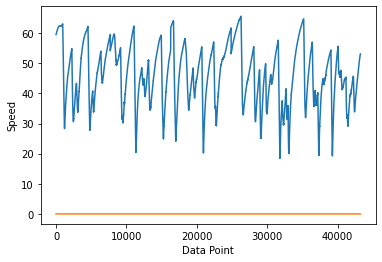

In [ ]:
# Base model 1: Zero Model
mses1 = []
for i in range (y_test.shape[0]):
  mse1 = (y_test[i])**2
  mses1.append(mse1)
zero_final_mse = 1/y_test.shape[0]*(np.sum(mses1))
print("Zero MSE: ", zero_final_mse)

# plot
plt.figure
plt.plot(y_test)
plt.plot(np.zeros(y_test.shape[0]))
plt.xlabel("Data Point")
plt.ylabel("Speed")

Average MSE:  96.60526237461283


Text(0, 0.5, 'Speed')

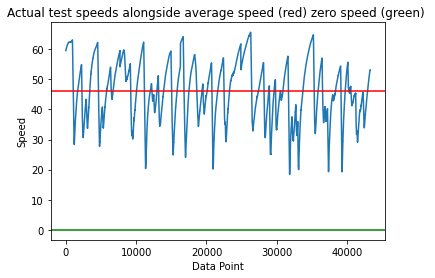

In [ ]:
# Base model 2: average Model
y_average = np.average(y_test)
mses2 = []
for i in range (y_test.shape[0]):
  mse2 = (y_average-y_test[i])**2
  mses2.append(mse2)
average_final_mse = 1/y_test.shape[0]*(np.sum(mses2))
print("Average MSE: ", average_final_mse)

#plot
plt.figure
plt.plot(y_test)
plt.axhline(y=y_average, color='r', linestyle='-')
plt.axhline(y=0, color='g')
plt.title("Actual test speeds alongside average speed (red) zero speed (green) ")
plt.xlabel("Data Point")
plt.ylabel("Speed")

In [ ]:
def linear_regression(X, Y, Xs_test, Ys_test):
    """
    This function performs linear regression.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """

    ## YOUR CODE HERE
    ### start linReg ### 
    X=np.asarray(X)
    n,m = X.shape
    X0 = np.ones((n,1))
    X = np.hstack((X,X0))
    Y=np.asarray(Y)
    Xs_test=np.asarray(Xs_test)
    n1,m1=Xs_test.shape
    X1 = np.ones((n1,1))
    Xs_test=np.hstack((Xs_test,X1))
    Ys_test=np.asarray(Ys_test)

    w = np.linalg.solve(X.T.dot(X), X.T.dot(Y))

    mses = []
    differences = []
    Y_actual_min = 9999
    Y_actual_max = 0

    for i, X_test in enumerate(Xs_test):
        Y_pred = X_test.dot(w)
        mse = (Y_pred - Ys_test[i])**2
        if Ys_test[i] < Y_actual_min:
          Y_actual_min = Ys_test[i]
        if Ys_test[i] > Y_actual_max:
          Y_actual_max = Ys_test[i]
        difference = abs(Y_pred-Ys_test[i])
        differences.append(difference)
        mses.append(mse)

    mses=np.asarray(mses)
    mse1=(np.sum(mses,axis=None))/Xs_test.shape[0]
    ### end linReg ###
    return mse1, Y_pred, w, differences

MSE Linear Regression:  44.36872241743319
w:  [-1.00734139e-01 -4.51914275e-02 -1.04819691e-01 -5.58233523e+02
 -2.04910343e+02 -5.20815788e+02  5.87067857e+01]


Text(0, 0.5, 'Difference')

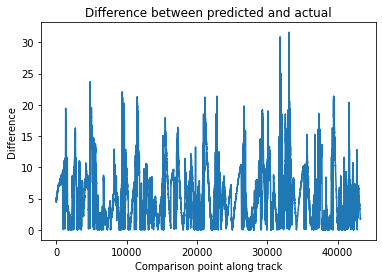

In [ ]:
# Run OLS
mse_linear_regression, y_predict, w, differences = linear_regression(phi,y,phi_test,y_test)
print("MSE Linear Regression: ", mse_linear_regression)
print("w: ", w)

plt.figure
plt.plot(differences)
plt.title("Difference between predicted and actual")
plt.xlabel("Comparison point along track")
plt.ylabel("Difference")

In [ ]:
# Ordinary Least Squares (Linear Regression)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(phi, y)
print("w: ", reg.coef_)
print("Intercept: ",reg.intercept_)
y_pred = reg.predict(phi_test)
mses = []
for i in range (y_pred.shape[0]):
  mse = (y_pred[i]-y_test[i])**2
  mses.append(mse)
ols_final_mse = 1/y_pred.shape[0]*(np.sum(mses))
print("MSE: ", ols_final_mse)

w:  [-1.00734139e-01 -4.51914275e-02 -1.04819691e-01 -5.58233523e+02
 -2.04910343e+02 -5.20815788e+02]
Intercept:  58.70678568630386
MSE:  44.36872241743625


Best Alpha Val:  0
Minimimum MSE:  44.36872241743625


Text(0, 0.5, 'Mean Squared Error (MSE)')

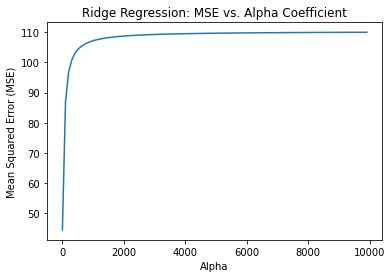

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge
min_mse = ols_final_mse
min_alpha_val = 0
alphas = []
final_mses = []
for i in range(100):
  alpha_val = i*100
  alphas.append(alpha_val)
  ridge_reg = Ridge(alpha=alpha_val)
  ridge_reg.fit(phi,y)
  y_pred = ridge_reg.predict(phi_test)
  mses = []
  for i in range (y_pred.shape[0]):
    mse = (y_pred[i]-y_test[i])**2
    mses.append(mse)
  final_mse = 1/y_pred.shape[0]*(np.sum(mses))
  final_mses.append(final_mse)
  if final_mse < min_mse:
    min_mse = final_mse
    min_alpha_val = alpha_val
print("Best Alpha Val: ", min_alpha_val)
print("Minimimum MSE: ", min_mse)
plt.figure
plt.plot(alphas,final_mses)
plt.title("Ridge Regression: MSE vs. Alpha Coefficient")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error (MSE)")

In [ ]:
# Ridge Regression with validation tuning of hyperparameter
from sklearn.linear_model import RidgeCV
ridge_reg_new = RidgeCV(alphas=[5]).fit(phi,y)
y_pred = ridge_reg_new.predict(phi_test)
mses = []
for i in range (y_pred.shape[0]):
    mse = (y_pred[i]-y_test[i])**2
    mses.append(mse)
final_mse = 1/y_pred.shape[0]*(np.sum(mses))
print("MSE: ",final_mse)

MSE:  46.19527508928689


In [ ]:
# Polynomial features order 2-->4 (may not be possible to run 3 and 4 depending on RAM)
from sklearn.preprocessing import PolynomialFeatures
min_mse_poly = 999
min_order = 0 
final_mse_polys = []
for i in range(2,5): # edit the second number here to 3 or 4 if not enough RAM
  poly = PolynomialFeatures(degree=i)
  phi_poly2 = poly.fit_transform(phi)
  phi_poly2_test = poly.fit_transform(phi_test)
  #print(phi_poly2.shape)
  reg = LinearRegression().fit(phi_poly2, y)
  print("Polynomial order: ", i)
  print("w: ", reg.coef_)
  print("Intercept: ",reg.intercept_)
  y_pred = reg.predict(phi_poly2_test)
  mses = []
  for i2 in range (y_pred.shape[0]):
    mse = (y_pred[i2]-y_test[i2])**2
    #print("Y test: ", y_test[i])
    #print("Y pred: ", y_pred[i])
    mses.append(mse)
  final_mse_poly = 1/y_pred.shape[0]*(np.sum(mses))
  final_mse_polys.append(final_mse_poly)
  if final_mse_poly < min_mse_poly:
    min_mse_poly = final_mse_poly
    min_order = i
  print("MSE: ", final_mse_poly)
print("Best order: ", min_order)
print("Minimum MSE: ", min_mse_poly)

Polynomial order:  2
w:  [-1.63624568e-08 -9.26285592e+00  2.67430166e+00  6.58335437e+00
 -9.85397193e+02 -1.30065277e+02 -9.13842265e+02 -1.56929897e-02
 -1.38983373e-01  1.05444015e-01  1.11879957e+02  2.10442426e+02
  8.98122295e+01  5.14247667e-02 -2.07122947e-02 -1.18064073e+02
 -1.34693571e+02  1.73872132e+02  1.35089349e-03  1.29327160e+01
 -6.85052777e+01 -2.55713850e+02 -2.99283892e+03  5.99327443e+03
  2.19562518e+04 -5.21334814e+03  4.26530193e+03 -3.54923884e+03]
Intercept:  59.326224110355014
MSE:  40.63637129336872
Polynomial order:  3
w:  [-1.22618882e-01 -7.82420171e+01  3.73994606e+01  3.62923311e+01
 -5.14668311e+02 -4.86495381e+02 -4.43326119e+02 -1.02602943e+01
 -9.99193742e+00  3.84141585e+01 -8.90619762e+02  4.19621493e+03
 -9.27039786e+02  1.63927283e+01 -2.69726828e+01  1.50478216e+03
 -6.83566883e+03  3.88266229e+03 -7.19904932e+00 -7.16301138e+02
  2.71262695e+03 -3.04155195e+03 -3.54235227e+04  6.87001927e+04
  6.18339603e+04 -6.10842842e+04  4.52731545e+04 

[44.36872241743319, 40.63637129336872, 40.6275481924971, 41.75325770261631]


Text(0, 0.5, 'Mean Squared Error (MSE)')

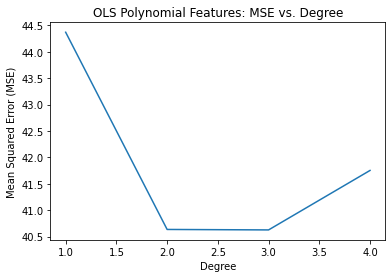

In [ ]:
# Plot of MSE vs. Polynomial degree - Rerunning
plt.figure
final_mse_polys.insert(0,mse_linear_regression)
print(final_mse_polys)
plt.plot([1,2,3,4],final_mse_polys[:4])
plt.title("OLS Polynomial Features: MSE vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Mean Squared Error (MSE)")

In [ ]:
# OLS and then Ridge Regression for Polynomial Degree two augmented features
#poly = PolynomialFeatures(degree=2)
#phi_poly2 = poly.fit_transform(phi)
#phi_poly2_test = poly.fit_transform(phi_test)
#reg = LinearRegression().fit(phi_poly2, y)
#y_pred = reg.predict(phi_poly2_test)
#mses = []
#for i2 in range(y_pred.shape[0]):
#  mse = (y_pred[i2]-y_test[i2])**2
#  mses.append(mse)
#final_mse_poly2 = 1/y_pred.shape[0]*(np.sum(mses))

# start of ridge regression
alpha_vals = []
mses_total = []
for i3 in range(10):
  alpha_val_poly2 = i3
  alpha_vals.append(alpha_val_poly2)
  ridge_reg2 = Ridge(alpha=alpha_val_poly2)
  ridge_reg2.fit(phi_poly2,y)
  #print("w: ", ridge_reg2.coef_)
  #print("Intercept: ", ridge_reg2.intercept_)
  y_pred = ridge_reg2.predict(phi_poly2_test)
  mses = []
  for i in range (y_pred.shape[0]):
    mse = (y_pred[i]-y_test[i])**2
    mses.append(mse)
  final_mse = 1/y_pred.shape[0]*(np.sum(mses))
  mses_total.append(final_mse)
  #print("MSE: ",final_mse)

Text(0, 0.5, 'Mean Squared Error (MSE)')

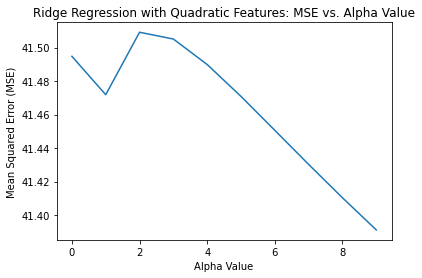

In [ ]:
# Plot of MSE vs. Polynomial degree 
plt.figure
plt.plot(alpha_vals,mses_total)
plt.title("Ridge Regression with Quadratic Features: MSE vs. Alpha Value")
plt.xlabel("Alpha Value")
plt.ylabel("Mean Squared Error (MSE)")

In [ ]:
# OLS and then Ridge Regression for Polynomial Degree two augmented features
poly3 = PolynomialFeatures(degree=3)
phi_poly3 = poly.fit_transform(phi)
phi_poly3_test = poly.fit_transform(phi_test)
reg3 = LinearRegression().fit(phi_poly3, y)
y_pred3 = reg.predict(phi_poly3_test)
mses3 = []
for i3 in range(y_pred3.shape[0]):
  mse3 = (y_pred3[i3]-y_test[i3])**2
  mses3.append(mse3)
final_mse_poly3 = 1/y_pred3.shape[0]*(np.sum(mses3))

# start of ridge regression
alpha_vals3 = []
mses_total3 = []
for i3 in range(10):
  alpha_val_poly3 = i3
  alpha_vals3.append(alpha_val_poly3)
  ridge_reg3 = Ridge(alpha=alpha_val_poly3)
  ridge_reg3.fit(phi_poly3,y)
  #print("w: ", ridge_reg2.coef_)
  #print("Intercept: ", ridge_reg2.intercept_)
  y_pred3 = ridge_reg3.predict(phi_poly3_test)
  mses3 = []
  for i4 in range (y_pred3.shape[0]):
    mse3 = (y_pred3[i4]-y_test[i4])**2
    mses3.append(mse3)
  final_mse3 = 1/y_pred3.shape[0]*(np.sum(mses3))
  mses_total3.append(final_mse3)
  #print("MSE: ",final_mse)

Text(0, 0.5, 'Mean Squared Error (MSE)')

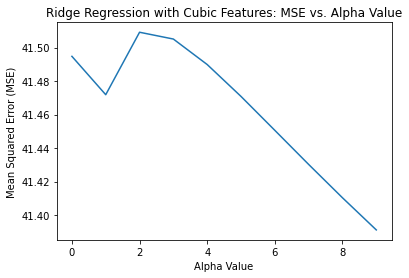

In [ ]:
# Plot of MSE vs. Polynomial degree 
plt.figure
plt.plot(alpha_vals3,mses_total3)
plt.title("Ridge Regression with Cubic Features: MSE vs. Alpha Value")
plt.xlabel("Alpha Value")
plt.ylabel("Mean Squared Error (MSE)")

In [ ]:
# Ridge Regression with validation
from sklearn.linear_model import RidgeCV
ridge_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 180]).fit(phi_poly2,y)
ridge_reg.score(phi_poly2,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:1480: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2


-6.0125422654429224e+16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7434667.094826495, tolerance: 2899.596338429767
  positive)


Best Alpha Val:  0.0
Minimimum MSE:  44.36872241743642


Text(0, 0.5, 'Mean Squared Error (MSE)')

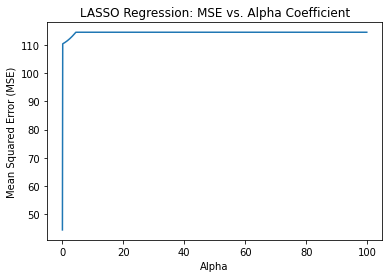

In [ ]:
# LASSO
from sklearn import linear_model
min_mse2 = 999
min_alpha_val2 = 0
alphas2 = []
final_mses2 = []
for i in np.arange(1,25,2):
  alpha_val2 = i*0.1
  alphas2.append(alpha_val2)
  lasso_reg = linear_model.Lasso(alpha=alpha_val2)
  lasso_reg.fit(phi,y)
  y_pred2 = lasso_reg.predict(phi_test)
  mses2 = []
  for i in range (y_pred.shape[0]):
    mse2 = (y_pred2[i]-y_test[i])**2
    mses2.append(mse2)
  final_mse2 = 1/y_pred2.shape[0]*(np.sum(mses2))
  final_mses2.append(final_mse2)
  if final_mse2 < min_mse2:
    min_mse2 = final_mse2
    min_alpha_val2 = alpha_val2
  #print("MSE: ",final_mse)
print("Best Alpha Val: ", min_alpha_val2)
print("Minimimum MSE: ", min_mse2)
plt.figure
plt.plot(alphas2,final_mses2)
plt.title("LASSO Regression: MSE vs. Alpha Coefficient")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error (MSE)")

In [ ]:
# LASSO
poly = PolynomialFeatures(degree=2)
phi_poly2 = poly.fit_transform(phi)
phi_poly2_test = poly.fit_transform(phi_test)
reg = LinearRegression().fit(phi_poly2, y)
y_pred = reg.predict(phi_poly2_test)
mses = []
for i2 in range(y_pred.shape[0]):
  mse = (y_pred[i2]-y_test[i2])**2
  mses.append(mse)
final_mse_poly2 = 1/y_pred.shape[0]*(np.sum(mses))
min_mse2 = 999
min_alpha_val2 = 0
alphas2 = []
final_mses2 = []
for i in range(10):
  alpha_val2 = i*0.1
  alphas2.append(alpha_val2)
  lasso_reg = linear_model.Lasso(alpha=alpha_val2)
  lasso_reg.fit(phi_poly2,y)
  y_pred2 = lasso_reg.predict(phi_poly2_test)
  mses2 = []
  for i in range (y_pred.shape[0]):
    mse2 = (y_pred2[i]-y_test[i])**2
    mses2.append(mse2)
  final_mse2 = 1/y_pred2.shape[0]*(np.sum(mses2))
  final_mses2.append(final_mse2)
  if final_mse2 < min_mse2:
    min_mse2 = final_mse2
    min_alpha_val2 = alpha_val2
  #print("MSE: ",final_mse)
print("Best Alpha Val: ", min_alpha_val2)
print("Minimimum MSE: ", min_mse2)
plt.figure
plt.plot(alphas2,final_mses2)
plt.title("Lasso Regression Qudratic features: MSE vs. Alpha Coefficient")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error (MSE)")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7033883.272190827, tolerance: 2899.596338429767
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8254513.559207277, tolerance: 2899.596338429767
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:47

In [ ]:
## Vary La with fixed 2 degree polynomial 
feature_keys = ['width','kap1'] # what features you want (possible keys printed above)
La = 5 # number of lookahead steps
Lb = 5 # number of look behind steps
ds = 2 # distance between steps (m)

# Change lookahead params with poly 2 
from sklearn.preprocessing import PolynomialFeatures
min_mse_poly = 999
min_order = 0 
final_mse_Las = []
i = 2
N = 20
for La in range(0,N):
  print("La: ", La)
  phi, phi_course = construct_mega_phi(feature_keys,La,Lb,ds,train_course)
  phi_course = phi_course.reshape(-1)
  phi_test, phi_course_test = construct_mega_phi(feature_keys,La,Lb,ds,test_course)
  phi_course_test = phi_course_test.reshape(-1)
  y = reduce_data(train_course, 'speed', La,Lb,ds)
  y_test = reduce_data(test_course, 'speed', La,Lb,ds)
  poly = PolynomialFeatures(degree=i)
  phi_poly2 = poly.fit_transform(phi)
  phi_poly2_test = poly.fit_transform(phi_test)
  reg = LinearRegression().fit(phi_poly2, y)
  y_pred = reg.predict(phi_poly2_test)
  mses = []
  for i2 in range (y_pred.shape[0]):
    mse = (y_pred[i2]-y_test[i2])**2
    mses.append(mse)
  final_mse_La = 1/y_pred.shape[0]*(np.sum(mses))
  final_mse_Las.append(final_mse_La)


In [ ]:
## Vary Lb with fixed 2 degree polynomial 

feature_keys = ['width','kap1'] # what features you want (possible keys printed above)
La = 5 # number of lookahead steps
Lb = 5 # number of look behind steps
ds = 2 # distance between steps (m)

from sklearn.preprocessing import PolynomialFeatures
min_mse_poly = 999
min_order = 0 
final_mse_Lbs = []
i = 2
for Lb in range(0,N):
  print("Lb: ", Lb)
  phi, phi_course = construct_mega_phi(feature_keys,La,Lb,ds,train_course)
  phi_course = phi_course.reshape(-1)
  phi_test, phi_course_test = construct_mega_phi(feature_keys,La,Lb,ds,test_course)
  phi_course_test = phi_course_test.reshape(-1)
  y = reduce_data(train_course, 'speed', La,Lb,ds)
  y_test = reduce_data(test_course, 'speed', La,Lb,ds)
  poly = PolynomialFeatures(degree=i)
  phi_poly2 = poly.fit_transform(phi)
  phi_poly2_test = poly.fit_transform(phi_test)
  reg = LinearRegression().fit(phi_poly2, y)
  y_pred = reg.predict(phi_poly2_test)
  mses = []
  for i2 in range (y_pred.shape[0]):
    mse = (y_pred[i2]-y_test[i2])**2
    mses.append(mse)
  final_mse_Lb = 1/y_pred.shape[0]*(np.sum(mses))
  final_mse_Lbs.append(final_mse_Lb)

plt.figure()
plt.plot(range(0,N),final_mse_Lbs)
plt.ylabel('MSE')
plt.xlabel('Lb')
plt.show()

In [ ]:
# Vary ds with fixed 2 degree polynomial

feature_keys = ['width','kap1'] # what features you want (possible keys printed above)
La = 10 # number of lookahead steps
Lb = 10 # number of look behind steps
ds = 2 # distance between steps (m)

from sklearn.preprocessing import PolynomialFeatures
min_mse_poly = 999
min_order = 0 
final_mse_dss = []
i = 2
for ds in np.arange(1,30,2.5):
  print("ds: ", ds)
  phi, phi_course = construct_mega_phi(feature_keys,La,Lb,ds,train_course)
  phi_course = phi_course.reshape(-1)
  phi_test, phi_course_test = construct_mega_phi(feature_keys,La,Lb,ds,test_course)
  phi_course_test = phi_course_test.reshape(-1)
  y = reduce_data(train_course, 'speed', La,Lb,ds)
  y_test = reduce_data(test_course, 'speed', La,Lb,ds)
  poly = PolynomialFeatures(degree=i)
  phi_poly2 = poly.fit_transform(phi)
  phi_poly2_test = poly.fit_transform(phi_test)
  reg = LinearRegression().fit(phi_poly2, y)
  y_pred = reg.predict(phi_poly2_test)
  mses = []
  for i2 in range (y_pred.shape[0]):
    mse = (y_pred[i2]-y_test[i2])**2
    mses.append(mse)
  final_mse_ds = 1/y_pred.shape[0]*(np.sum(mses))
  final_mse_dss.append(final_mse_ds)

plt.figure()
plt.plot(np.arange(.5,20,.5),final_mse_dss)
plt.ylabel('MSE')
plt.xlabel('ds')
plt.show()

In [ ]:
## Cross validation search for ds hyperparamter
def mse_vary_ds(La,Lb,train_course,test_course,s): 
  final_mse_dss = []
  i = 2
  for ds in s:
    print("ds: ", ds)
    phi, phi_course = construct_mega_phi(feature_keys,La,Lb,ds,train_course)
    phi_course = phi_course.reshape(-1)
    phi_test, phi_course_test = construct_mega_phi(feature_keys,La,Lb,ds,test_course)
    phi_course_test = phi_course_test.reshape(-1)
    y = reduce_data(train_course, 'speed', La,Lb,ds)
    y_test = reduce_data(test_course, 'speed', La,Lb,ds)
    poly = PolynomialFeatures(degree=i)
    phi_poly2 = poly.fit_transform(phi)
    phi_poly2_test = poly.fit_transform(phi_test)
    reg = LinearRegression().fit(phi_poly2, y)
    y_pred = reg.predict(phi_poly2_test)
    mses = []
    for i2 in range (y_pred.shape[0]):
      mse = (y_pred[i2]-y_test[i2])**2
      mses.append(mse)
    final_mse_ds = 1/y_pred.shape[0]*(np.sum(mses))
    final_mse_dss.append(final_mse_ds)
  return final_mse_dss

La = 10 # number of lookahead steps
Lb = 10 # number of look behind steps
s = np.arange(7,27,2.5)
min_ds = []
for i in range(0,len(un_course)):
  test_course = np.array([un_course[i]]) # which tracks from un_course you wish to train; un_course is identifier for all the courses available 
  train_course = np.delete(un_course,i)
  mse = mse_vary_ds(La,Lb,train_course,test_course,s)
  min_mse_idx = mse.index(min(mse))
  print('MSE_index: ',min_mse_idx, '  best s: ', s[min_mse_idx])
  min_ds.append(s[min_mse_idx])